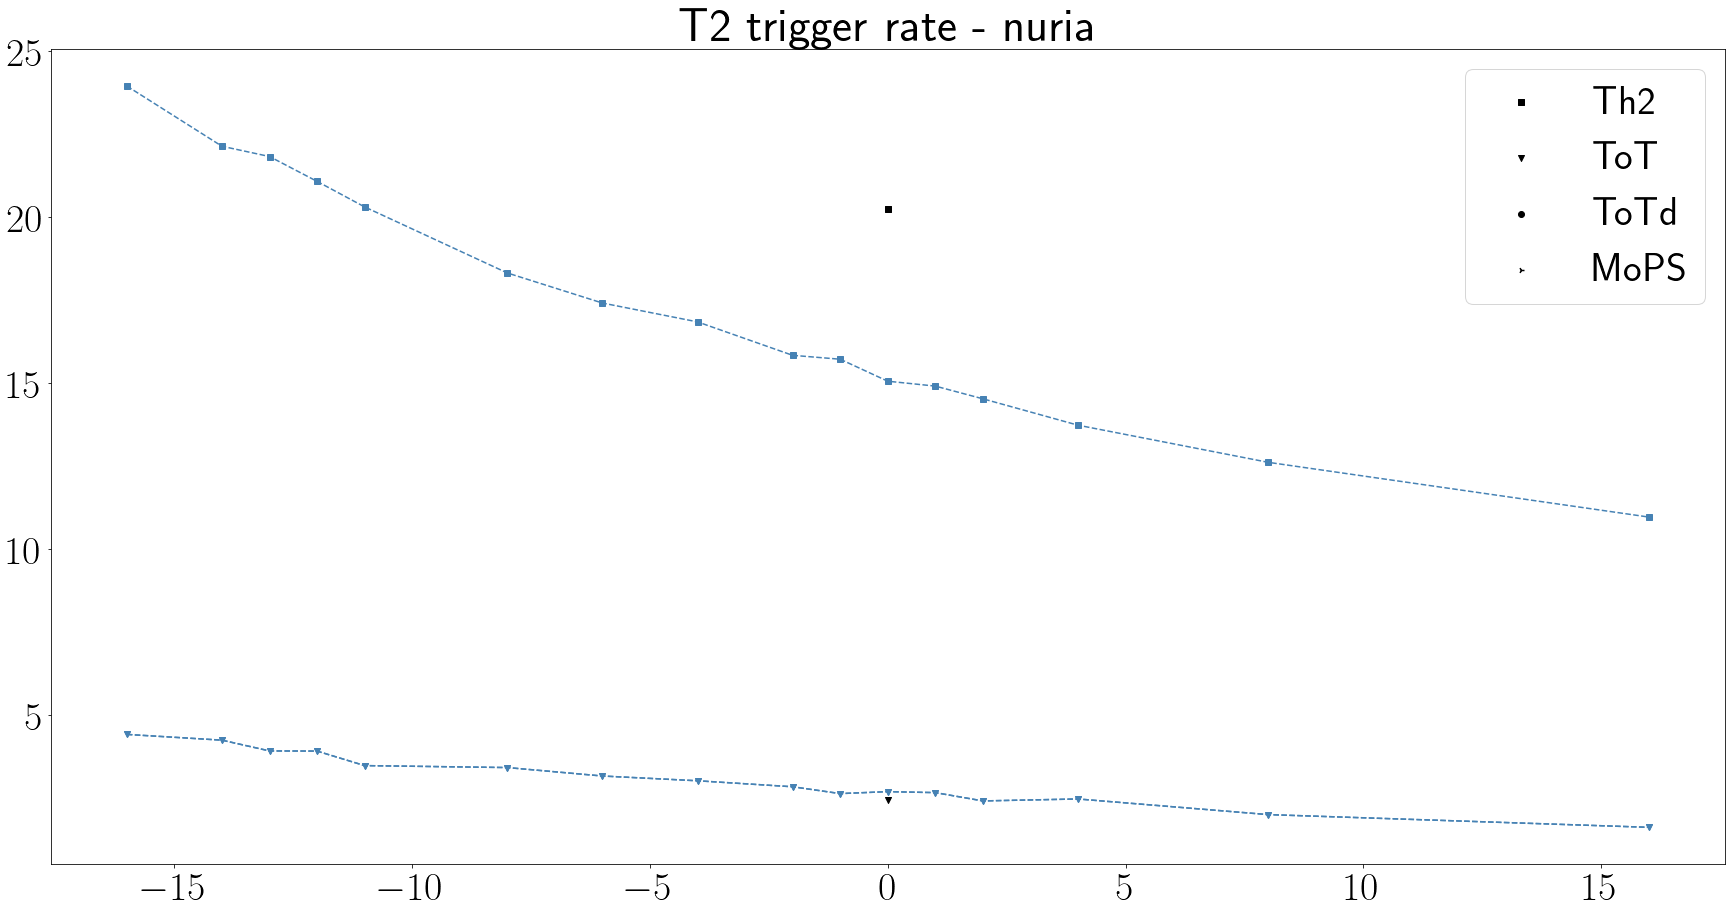

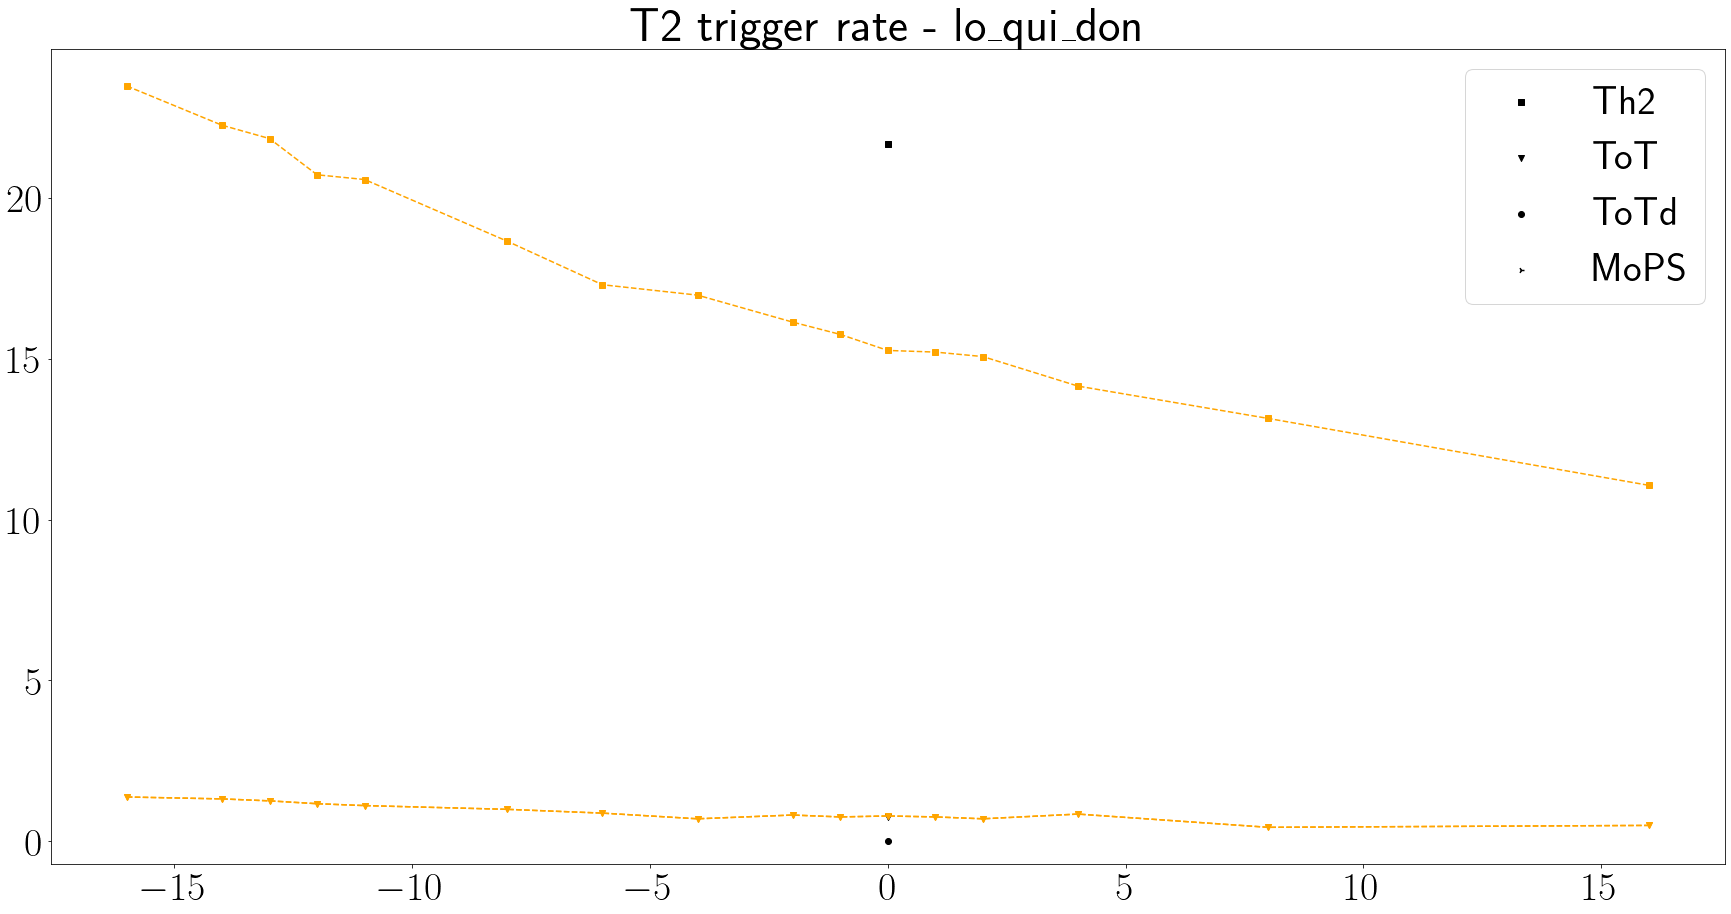

In [25]:
from Binaries import *
import uproot

def neg_exponential(x, a, b):
    return a * np.exp(- b * x)

stations = \
    {
        "nuria" : 56,
        "lo_qui_don" : 1744,
    }

colors = \
    {
        "nuria" : "steelblue",
        "lo_qui_don" : "orange",
    }


production_test_path = "/cr/users/filip/Trigger/RunProductionTest/trigger_output_componentwise/" 
file = uproot.open("/cr/tempdata01/filip/iRODS/MonitoringData/mc_2022_03_17_00h00.root:SDMonCal")

for directory in os.listdir("./trigger_output_with_mops"):

    file = uproot.open("/cr/tempdata01/filip/iRODS/MonitoringData/mc_2022_03_17_00h00.root:SDMonCal")
    StationIDs = file['SDMonCalBranch']['fLsId'].array()
    data = file['fCalibration']

    # Because fEndSecond is given relative to fStartSecond, we dont need this
    # start = data['fCalibration.fStartSecond'].array()[StationIDs == stations[directory]]
    stop = data['fCalibration.fEndSecond'].array()[StationIDs == stations[directory]]
    n_t2 = data['fCalibration.fT2'].array()[StationIDs == stations[directory]]
    r_tot = np.mean(data['fCalibration.fTotRate'].array()[StationIDs == stations[directory]])
    r_totd = np.mean(data['fCalibration.fTotD'].array()[StationIDs == stations[directory]])
    r_mops = np.mean(data['fCalibration.fMops'].array()[StationIDs == stations[directory]])
    r_th2 = np.mean(n_t2 / stop) - r_tot - r_totd - r_mops
    online_rate_all = np.mean(n_t2 / stop)
    online_rate_err = np.std(n_t2 / stop)

    x_vals = []
    my_th2, my_tot, my_totd, my_mops = [], [], [], []

    plt.figure()
    # plt.errorbar(0, online_rate, yerr = online_rate_err, c = "k", fmt = "*", markersize = 20, label = r"Absolute rate")
    plt.scatter(0, r_th2, marker = "s", c = "k", label = "Th2")
    plt.scatter(0, r_tot, marker = "v", c = "k", label = "ToT")
    plt.scatter(0, r_totd, marker = "o", c = "k", label = "ToTd")
    plt.scatter(0, r_mops, marker = "4", c = "k", label = "MoPS")

    for file in os.listdir(f"{production_test_path}/{directory}/"):

        if os.path.isdir(f"{production_test_path}/{directory}/{file}"): continue

        # FILENAME        n    t        sum th   tot totd    mops
        # randoms0499.csv 5000 0.084992 96  0    0   0       96

        # print("reading", "/cr/users/filip/Trigger/RunProductionTest/trigger_output_componentwise/" + directory + "/" + file)
        t, th, tot, totd, mops = np.loadtxt(production_test_path + directory + "/" + file, unpack = True, usecols = [2,4,5,6,7])

        x = float(file.split('_')[-1][1:-4])
        x *= -1 if file.split('_')[-1][0] == "m" else 1
        x_vals.append(x)

        my_th2.append(sum(th) / sum(t))
        my_tot.append(sum(tot) / sum(t))
        my_totd.append(sum(totd) / sum(t))
        my_mops.append(sum(mops) / sum(t))

    plt.title(f"T2 trigger rate - {directory}")

    ii = np.argsort(x_vals)
    x_vals = np.array(x_vals)[ii]
    my_th2 = np.array(my_th2)[ii]
    my_tot = np.array(my_tot)[ii]
    my_totd = np.array(my_totd)[ii]
    my_mops = np.array(my_mops)[ii]

    plt.errorbar(x_vals, my_th2, c = colors[directory], fmt = "--s")
    plt.errorbar(x_vals, my_tot, c = colors[directory], fmt = "--v")
    plt.errorbar(x_vals, my_totd, c = colors[directory], fmt = "--v")

    plt.legend()
    
    # closest = np.argmin(np.abs(online_rate - y_vals))

    # print(f"{directory} -- closest matching rate for {online_rate:.2f}: {y_vals[closest]:.2f} Hz at x = {x_vals[closest]:.0f}%")